# Air Quality Modeling - AQI Computation and Features

## D. Data Engineering: Long to Wide Transformation
We parse timestamps and coordinates, then pivot to one row per (timestamp, location).
We use daily aggregation to reduce sparsity and align multi-pollutant readings.


(10722, 10)


,city,location,latitude,longitude,timestamp,co,no2,o3,pm10,so2
0,- LOC. CASA STABBI - Chitignano (AR),AR-CASA-STABBI,43.660280,11.901670,2025-01-10,NaN,NaN,NaN,10.0000,NaN
1,- LOC. CASA STABBI - Chitignano (AR),AR-CASA-STABBI,43.660280,11.901670,2025-01-11,NaN,1.062812,0.038203,NaN,NaN
2,-9999 - Acquapendente (VT),ACQUAPENDENTE,42.736572,11.876430,2025-01-11,NaN,2.125625,0.031581,NaN,NaN
3,"1010 Wien, Stephansplatz 1",Stephansplatz,48.208150,16.373254,2025-01-31,NaN,10.509363,0.022116,NaN,0.400165
4,1020 Wien,A23 SÃ¼dosttangente/WehlistraÃŸe,48.203060,16.434550,2025-01-31,0.207514,16.840507,NaN,13.0235,NaN


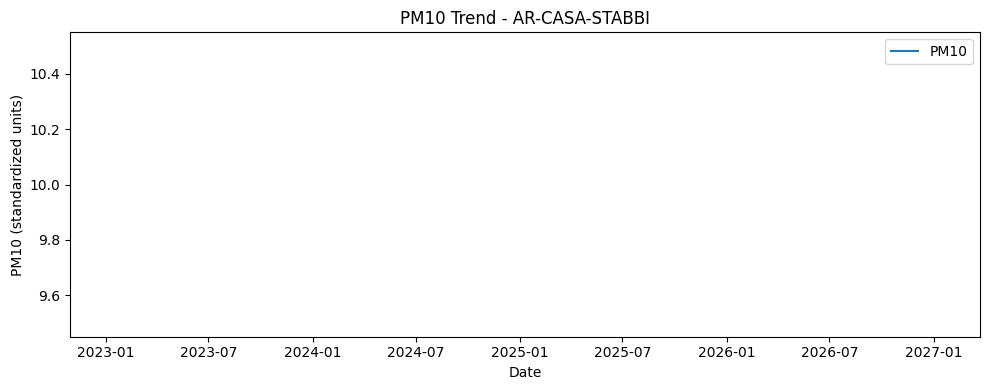

In [4]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path('..').resolve()
sys.path.append(str(ROOT / 'src'))

import importlib
import preprocessing
importlib.reload(preprocessing)

from preprocessing import aggregate_and_pivot


long_path = ROOT / 'data' / 'processed_long.csv'
long_df = pd.read_csv(long_path, parse_dates=['timestamp'])

wide_df = aggregate_and_pivot(long_df, freq='D')
print(wide_df.shape)
display(wide_df.head())

processed_wide_path = ROOT / 'data' / 'processed_wide.csv'
wide_df.to_csv(processed_wide_path, index=False)

# Plot: time series for a sample location
sample_location = wide_df['location'].iloc[0]
sample = wide_df[wide_df['location'] == sample_location].sort_values('timestamp')
plt.figure(figsize=(10, 4))
pollutant_for_plot = 'pm25' if 'pm25' in sample.columns else (
            "pm10" if 'pm10' in sample.columns else sample.select_dtypes('number').columns[-1]
        )
plt.plot(sample['timestamp'], sample[pollutant_for_plot], label=pollutant_for_plot.upper())
plt.title(f'{pollutant_for_plot.upper()} Trend - {sample_location}')
plt.xlabel('Date')
plt.ylabel(f'{pollutant_for_plot.upper()} (standardized units)')
plt.legend()
plt.tight_layout()
plt.show()


## E. AQI Computation
We use the US EPA AQI breakpoints. The Individual AQI (IAQI) formula is:

IAQI = (Ihi - Ilo) / (BPhi - BPlo) * (C - BPlo) + Ilo

where C is the pollutant concentration and (BPlo, BPhi) are the breakpoints
that contain C with AQI range (Ilo, Ihi). AQI is the maximum IAQI across pollutants.


         aqi aqi_category
0   9.259259         Good
1  35.373264         Good
2  29.241898         Good
3  20.477818         Good
4  15.887271         Good


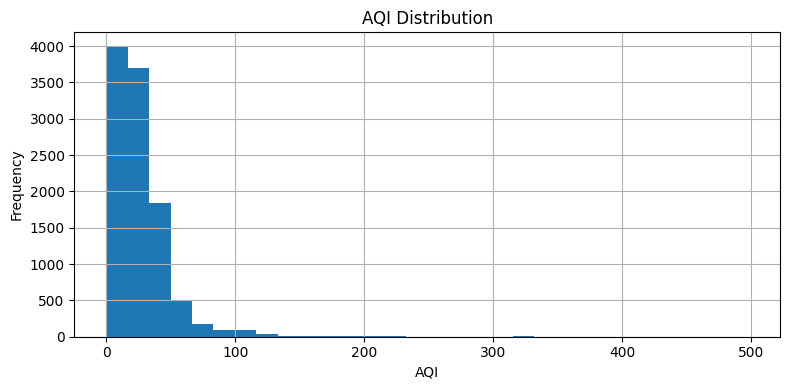

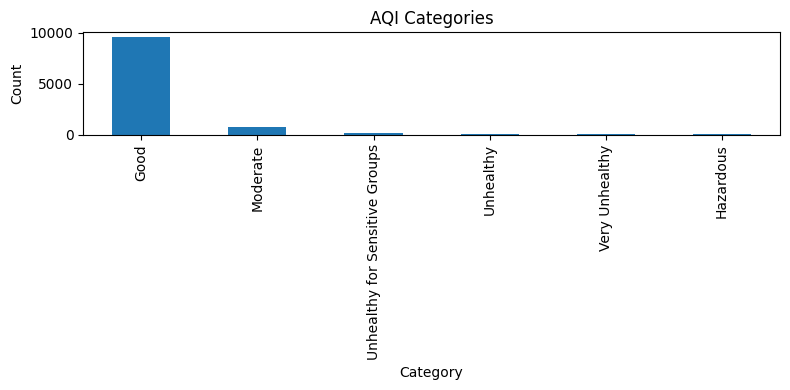

In [9]:
from aqi import compute_aqi_dataframe

aqi_df = compute_aqi_dataframe(wide_df)
print(aqi_df[['aqi', 'aqi_category']].head())

processed_aqi_path = ROOT / 'data' / 'processed_aqi.csv'
aqi_df.to_csv(processed_aqi_path, index=False)

# Plot: AQI distribution and categories
plt.figure(figsize=(8, 4))
aqi_df['aqi'].dropna().hist(bins=30)
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
aqi_df['aqi_category'].value_counts().plot(kind='bar')
plt.title('AQI Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## F. Feature Engineering
We create core pollutant features, time features, and optional lag features.


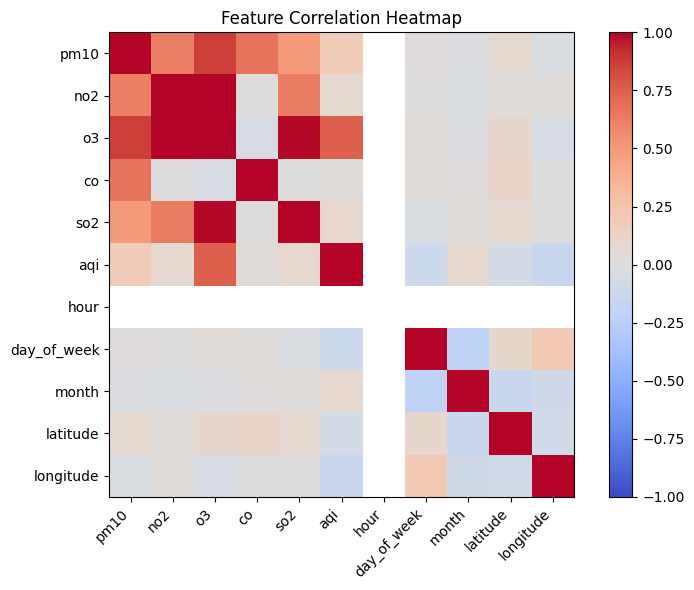

In [10]:
import importlib
import features
importlib.reload(features)

from features import add_time_features, add_lag_features


pollutant_cols = ['pm25', 'pm10', 'no2', 'o3', 'co', 'so2']

features_df = add_time_features(aqi_df, time_col='timestamp')
features_df = add_lag_features(
    features_df,
    group_cols=['location'],
    target_cols=pollutant_cols,
    lags=[1],
    time_col='timestamp',
)

processed_features_path = ROOT / 'data' / 'processed_features.csv'
features_df.to_csv(processed_features_path, index=False)

# Plot: correlation heatmap (numeric features only)
numeric_cols = pollutant_cols + ['aqi', 'hour', 'day_of_week', 'month', 'latitude', 'longitude']
numeric_cols = [c for c in numeric_cols if c in features_df.columns]
corr = features_df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()
